In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

path = '/content/drive/MyDrive/AI/CIFAR/'

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
from torchvision.utils import save_image

import numpy as np
import pathlib


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
pop_mean = []
pop_std = []

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 20
batch_size = 100
learning_rate = 0.001


In [7]:
pathlib.Path('./missclassified_img/').mkdir(parents=True, exist_ok=True) # Make dir if doesn't exist

In [8]:
!pwd

/content


In [9]:
misclassified_path="./missclassified_img/"

In [10]:
classes = ('airplane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [11]:


# CIFAR-10 dataset

dataset=torchvision.datasets.CIFAR10(root='./data/',
                                             train=True,                                            
                                             download=True,
                                             transform=transforms.ToTensor()
                                          )
data_loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=16,
                                         shuffle=True, 
                                         num_workers=2)

Files already downloaded and verified


### Find Normalization Values

In [12]:
for i, data in enumerate(data_loader,0):
    
    # shape (batch_size, 3, height, width)
    numpy_image = data[0].numpy() 
    
    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

In [13]:
pop_mean = np.array(pop_mean)
pop_std = np.array(pop_std)

In [14]:
pop_mean.shape, pop_std.shape

((3125, 3), (3125, 3))

In [15]:
pop_mean = pop_mean.mean(axis=0)
pop_std = pop_std.mean(axis=0)

In [16]:
print(pop_mean)
print(pop_std)

[0.49139997 0.48215848 0.44653118]
[0.2443028  0.24080025 0.25811765]


### Normalize dataset

In [17]:


# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(pop_mean,pop_std)])

test_transform = transforms.Compose([
    transforms.Pad(4),
    
    transforms.ToTensor(),
    transforms.Normalize(pop_mean,pop_std)])

train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                            
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform= test_transform)


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Files already downloaded and verified


In [18]:
def conv3x3(in_channels, out_channels, stride=1):
     #padding =1 to preserve input shape = output shape
     # stride <- et as ip as we do downsampling also
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)




class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__() # inherit everything from nn.Module
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels) # Apply bn to each output channels
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample # Check if there is a downsampling layer
        
    def forward(self, x): # input image first time. Next time onwards feature maps
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual # Output = Output + residual
        out = self.relu(out)
        return out




In [19]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10): 
        """
        layers wil be a list: [2,2,2] # There are 3 layers.  2 blocks for each layers
        """

        super(ResNet, self).__init__()
        self.in_channels = 16 # 16 kernels used first time
        self.conv = conv3x3(3, 16) # input channels, output channels
        self.bn = nn.BatchNorm2d(16) # dim is conv output feature map size
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
       
 
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(conv3x3(self.in_channels, out_channels, stride=stride),
                                       nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        self.after_layer1=out
        out = self.layer2(out)
        self.after_layer2=out
        out = self.layer3(out)
        self.after_layer3=out
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [20]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.005)



In [21]:
def train(epoch):
    decay = 0.0
    correct=0
    total=0.0
    accuracy=0.0
    
    model.train()
  # Decay the learning rate every 20 epochs
    if (epoch+1) % 20 == 0:
        decay+=1
        optimizer.param_groups[0]['lr'] = learning_rate * (0.5**decay)
        print("The new learning rate is {}".format(optimizer.param_groups[0]['lr']))
        
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        logps = model(images)
        batch_loss = criterion(logps, labels)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        train_losses.append(batch_loss.item())
        _, predicted = torch.max(logps.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy=100*correct/total
        train_accuracy.append(accuracy)
    print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}, Accuracy {:4f}"
        .format(epoch+1, num_epochs, i+1, len(train_loader), batch_loss.item(),accuracy))

  


In [26]:
def test(epoch):
  
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    accuracy=0
    count=0
    
    for images, labels in test_loader:
        count+=1
        images = images.to(device)
        labels = labels.to(device)
        logps = model(images)
        loss = criterion(logps, labels)
        _, predicted = torch.max(logps.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy=100*correct/total
        test_losses.append(loss.item())
        test_accuracy.append(accuracy)
        idxs_mask = ((predicted == labels) == False).nonzero()
        if (idxs_mask[-1] >0):
          incorrect_examples.append(images[idxs_mask].cpu().numpy())
          incorrect_labels.append(labels[idxs_mask].cpu().numpy())
          incorrect_prediction.append(predicted[idxs_mask].cpu().numpy())
          filename=misclassified_path+str(count)+'.png'
          save_image(images,filename)
          pred.append(pred)
          target.append(labels)
          
    print('Accuracy of the model on the test images: {} %'.format(accuracy))


In [27]:
start=time.time()
incorrect_examples = []
incorrect_labels=[]
incorrect_prediction=[]
pred=[]
target=[]
train_losses=[]
train_accuracy=[]

test_losses=[]
test_accuracy=[]

for epoch in range(num_epochs):

  train(epoch)   
  test(epoch)
    

elapsed=time.time()-start
print(elapsed,"seconds")    
print(elapsed/60,"minutes")       

Epoch [1/20], Step [500/500] Loss: 1.0141, Accuracy 65.788000
Accuracy of the model on the test images: 61.44 %
Epoch [2/20], Step [500/500] Loss: 0.9224, Accuracy 69.510000
Accuracy of the model on the test images: 69.48 %
Epoch [3/20], Step [500/500] Loss: 0.8513, Accuracy 71.746000
Accuracy of the model on the test images: 68.21 %
Epoch [4/20], Step [500/500] Loss: 0.6809, Accuracy 73.280000
Accuracy of the model on the test images: 63.64 %
Epoch [5/20], Step [500/500] Loss: 0.6233, Accuracy 74.446000
Accuracy of the model on the test images: 73.09 %
Epoch [6/20], Step [500/500] Loss: 0.7858, Accuracy 75.684000
Accuracy of the model on the test images: 70.48 %
Epoch [7/20], Step [500/500] Loss: 0.8014, Accuracy 76.194000
Accuracy of the model on the test images: 69.43 %
Epoch [8/20], Step [500/500] Loss: 0.5962, Accuracy 76.854000
Accuracy of the model on the test images: 74.45 %
Epoch [9/20], Step [500/500] Loss: 0.7536, Accuracy 77.372000
Accuracy of the model on the test images: 

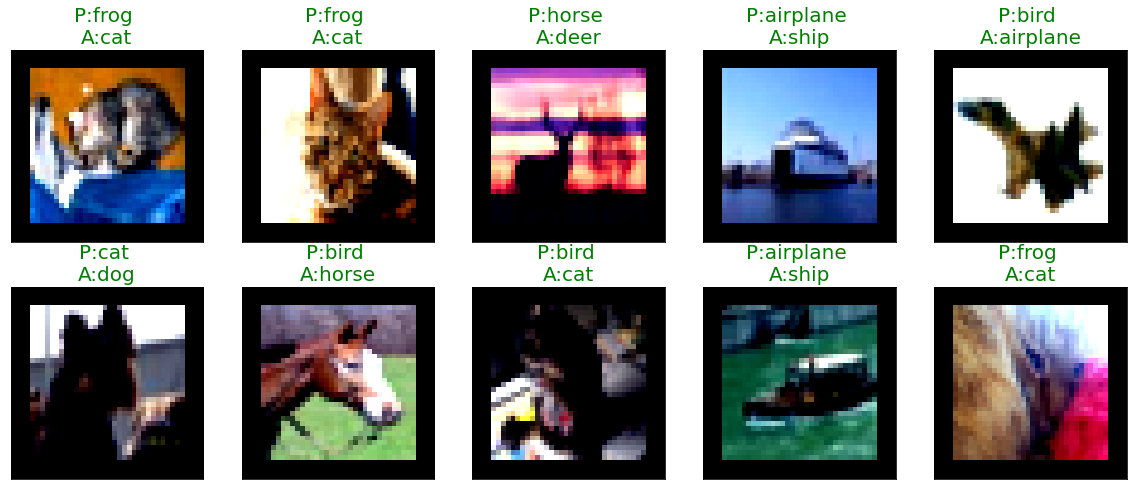

In [45]:
fig = plt.figure(figsize=(20, 8))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    std = np.array([0.229, 0.224, 0.225])
    mean = np.array([0.485, 0.456, 0.406])
    img = incorrect_examples[idx][idx]
   
    img = img/2 + 0.5
    img = np.clip(img, 0, 1)
    img = img[0, :,:,:].transpose(1,2,0)
    #print(img.shape)
    plt.imshow(img)
    incorrect_label_idx=incorrect_labels[idx][idx][0]

   # print(incorrect_label_idx)
    #print("predicted:",classes(incorrect_labels[idx][idx][0]))
   # print("Actual",classes[incorrect_label_idx])
    ax.set_title(f'P:{classes[incorrect_prediction[idx][idx][0]]} \nA:{classes[incorrect_label_idx]}', fontsize=20,color='green')
   
    plt.imshow(img)



In [46]:
!pip install pytorch-gradcam

In [47]:
import os
import PIL
import torch
import numpy as np
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def grad_cam(img, model, layer):
	configs = [dict(model_type='resnet', arch=model, layer_name=layer)]
	
	for config in configs:
		config['arch'].to(device).eval()
	
	torch_img = transforms.Compose([transforms.ToTensor()])(img).to(device)
	normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
	
	cams = [[cls.from_config(**config) for cls in (GradCAM, GradCAMpp)] for config in configs]	

	images = []
	for gradcam, gradcam_pp in cams:
		mask, _ = gradcam(normed_torch_img)
		heatmap, result = visualize_cam(mask, torch_img)

		mask_pp, _ = gradcam_pp(normed_torch_img)
		heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

		images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])

	return images

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


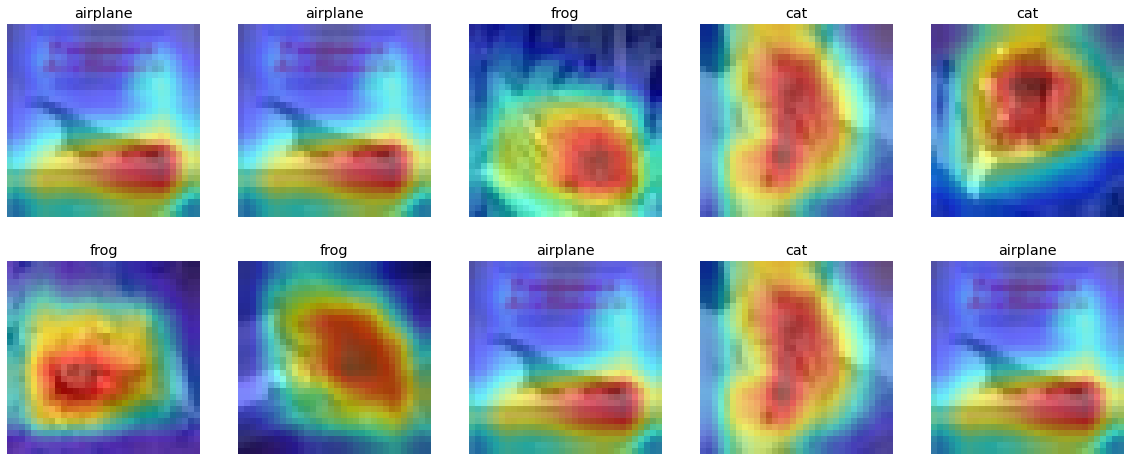

In [54]:
#from utils.gradcam import grad_cam

fig = plt.figure(figsize=(20, 8))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    img=test_dataset.data[incorrect_labels[idx][idx][0]]
    labels=test_dataset.targets[incorrect_labels[idx][idx][0]]
    layer= 'layer3'

    cam = grad_cam(img, model, layer)
    cam = torch.stack(cam)[4]
    cam = np.transpose(cam, (1, 2, 0))
    plt.axis("off")
    #plt.title(classes[incorrect_labels[idx][idx][0]])
    plt.title(classes[labels])
    plt.imshow(cam)

In [ ]:

!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

### Visualizing CNN

In [ ]:
images_batch, labels_batch = iter(train_loader).next()

In [ ]:
images_batch.shape

In [ ]:
labels_batch.shape

In [ ]:
img = torchvision.utils.make_grid(images_batch)
img.shape

In [ ]:
img = np.transpose(img, (1, 2, 0))
img.shape

In [ ]:
m, M = img.min(), img.max()

m, M

In [ ]:
#img = (1/(abs(m) * M)) * img + 0.5 

In [ ]:
img

In [ ]:
plt.figure (figsize = (16, 12))
plt.imshow(img)
plt.title(labels)
plt.axis("off")
plt.show()

In [ ]:
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [ ]:
classes = ('airplane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = figure.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
  ax.set_title(classes[labels[idx].item()])
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
 

### Plot Training VS Validation Loss

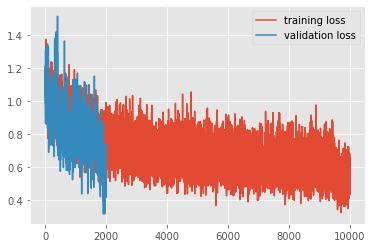

In [50]:
plt.style.use('ggplot')
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.legend()

### Plot Training vs Validation Accuracy

NameError: ignored

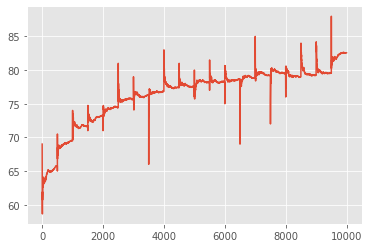

In [52]:
plt.style.use('ggplot')
plt.plot(train_accuracy, label='training accuracy')
plt.plot(test_accuracy_corrects_history, label='validation accuracy')
plt.legend()

### Visualizing Filters

In [ ]:
for inputs,logps in train_loader:
  inputs, labels = inputs.to(device), labels.to(device)
  figure=plt.figure()
  image=inputs[0][0]

  figure.add_subplot(3,6,1)
  plt.imshow(image)

  logps=model(inputs)

  layer_1 = model.after_layer1[0].detach()
  for i in range(3):
    figure.add_subplot(3,6,6+1+i)
    plt.imshow(layer_1[i])

  layer_2 = model.after_layer2[0].detach()
  for i in range(6):
    figure.add_subplot(3,6,12+1+i)
    plt.imshow(layer_2[i])  
plt.show()    


